In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn . preprocessing import StandardScaler
from sklearn . model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

# Intro

In this brief study, we will try to identify the best ML model for identifying fraudulent credit card transactions, using a deeply inbalanced dataset.

The sampling method is undersampling (1:1 ratio of target classes) which will be extended to weighted undersampling(1:100 ratio) to try to confirm our results.

The models we will use are:
1. Logistic Model
2. Random Forest
3. Gaussian Naive Bayes
4. Support vector Classifier   

They will be trained using scikit-learn and specifically optimized using GridSearchCV.


# 1 Class inbalance

In [2]:
#load data
data= pd.read_csv(r"C:\Users\Utente\OneDrive\Desktop\coding_project2\creditcard.csv")


#move class and amount in first position so we can clearly see the only tree variable we know
Amount = data["Amount"]
Class = data["Class"]
data.pop("Class")
data.pop("Amount")
data.insert(0,"Amount", Amount)
data.insert(0, "Class", Class)
data.head(2)

,Class,Amount,Time,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0,149.62,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,0,2.69,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724


We knew in advance that the dataset would be unbalanced.  
Let's visualize the ratio between frauds and legit transactions.

<function matplotlib.pyplot.show(close=None, block=None)>

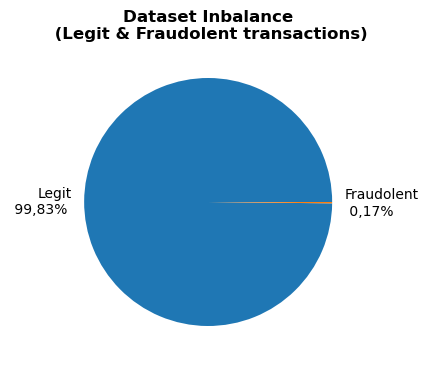

In [3]:
#pie chart
legit_transaction= data[data.Class == 0]
fraud_transaction= data[data.Class == 1]


perc_legit = len(legit_transaction)/len(data)
perc_fraud = len(fraud_transaction)/len(data)


percentages= np.array([perc_legit, perc_fraud])
mylables= ["Legit\n 99,83% ", "Fraudolent\n 0,17%"]

plt.figure(figsize = (4,5))
plt.pie(percentages, labels = mylables, shadow= False)
plt.title("Dataset Inbalance\n (Legit & Fraudolent transactions)", fontweight="bold")

plt.show


In [4]:
print("Ratio between legit and fraud transaction is: ", (perc_legit/perc_fraud))

Ratio between legit and fraud transaction is:  577.8760162601625


Thus, in our dataset there are 1 fraudulent transaction for every 578 legal transactions.  
This imbalance has strong effects on our models and accuracy measures to improve them.   
We then check how two basic models that we will use as benchmarks of this effect, a naive logistic model and a Zero model, perform.  

## 1.1 Naive Model

The Naive model is a logistic model that does not account for the inbalance:  
        1. It takes all the variables  
        2. It takes all observations without weighting them for class  
        3. It does not perform cross validation   

The model has an accuracy of 99.9 % but this is a misleading measure due to calss inbalance.


In [5]:
# NAIVE MODEL

X = data.drop(columns='Class', axis=1) #use std features
Y = data['Class']       

x_train , x_test , y_train , y_test = train_test_split (X , Y , test_size = 0.2,
                                                        stratify=Y,
                                                        random_state = 0)

#standardize the data
sc = StandardScaler ()
x_train = sc.fit_transform ( x_train )
x_test = sc.transform ( x_test )


#train and predict using the model
model = LogisticRegression(random_state= 0)
naive_model = model.fit(x_train, y_train)

y_pred = naive_model.predict ( x_test )

#check the accuracy 
an= str(accuracy_score(y_test,y_pred).round(4)*100)+" %"
print("\033[1m" + "Accuracy Naive Model: " + "\033[0m",an)

Accuracy Naive Model:  99.92 %


As a demostration let's see how a Zero Model that predicts always legit transactions (0) would score.



## 1.2 Zero Model

Simply classifying all transactions as legitimate would make us achieve an accuracy of 99.83% ,  
even higer than the naive logistic model!!!

In [6]:
#0 MODEL 
zeros =[0]* len(y_test)

az = str(accuracy_score(y_test,zeros).round(4)*100)+" %"
print("\033[1m" + "Accuracy Zero Model: " + "\033[0m",az)

Accuracy Zero Model:  99.83 %


So the first step is to find another measurement to test the accuracy of our models.

We can have two types of error in our prediction:    
* fraud_not_detected: The model fail to identify a fraudolent transaction  ( type 1 error )
* false_alarm: misclassify a legal transaction as a fraudolentolent one    ( type 2 error )
    
In this context we will consider two assumptions:  
  
1. A fraud not detected is much more serious in reputational and economic terms for the bank  
than a legitimate transaction  misclassified as fraud 

<!-- -->
2. The bank consequently prefers to minimize fraud_not_detected and not pay particular attention to false_alarms     
because a false allarm can be easily resolved by an automatic notification that ask the owner of the transaction.  


# 2 The toolbox

Following our assumptions we create the function "accuracy_measures" that returns: 
1. Confusion Matrix
2. Accuracy score  
3. Percentage frauds not detected
4. Percentage of false alarms  

And from it we derive the  function "frauds_not_detected" that will be the objective function to minimize.

The "accuracy_measures" function will also be used to check how the model performed in the training set to eavluate overfitting.

In [7]:
#compute the perc_fraud_not dected
def accuracy_measures(y_test,y_pred):
    #compute confusion_matrixusion matrix
    cm = confusion_matrix(y_test,y_pred)
    cm = pd.DataFrame(cm, columns=("legit prediction","fraud prediction"), index=("legit ","fraud"))
    #compute percentage fraud non detected
    perc_fraud_not_detected = ((cm.iloc[1,0]/(cm.iloc[1,1]+cm.iloc[1,0]))*100).round(2)
    perc_fraud_not_detected = str(perc_fraud_not_detected.round(2))+" %"
    
    #compute percentage false fraud alarm
    perc_false_alarm = ((cm.iloc[0,1]/(cm.iloc[0,0]+cm.iloc[0,1]))*100).round(2)
    perc_false_alarm = str(perc_false_alarm.round(2))+" %"
  

    print("\033[1m" + "Confusion matrix: " + "\033[0m")
    print(cm)
    print()
    print("\033[1m" + "Accuracy Score: " + "\033[0m")
    print(str(accuracy_score(y_test,y_pred).round(4)*100)+" %")
    print()
    print("\033[1m" + "Percentage of frauds not detected: " + "\033[0m")
    print(perc_fraud_not_detected)
    print()
    print("\033[1m" + "Percentage of false alarms: " + "\033[0m")
    print( perc_false_alarm)

def frauds_not_detected(y_test, y_pred):
    # Compute confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, columns=("legit prediction", "fraud prediction"), index=("legit", "fraud"))
    # Compute percentage fraud not detected
    perc_fraud_not_detected = (cm.iloc[1, 0] / (cm.iloc[1, 1] + cm.iloc[1, 0])) * 100
    perc_fraud_not_detected = perc_fraud_not_detected.round(2)
    return perc_fraud_not_detected

Now we can see how rely on Accuracy is actually misleading.  
Both Naive and 0 Model have 99% accuracy but perform very poorly in detecting the few frauds we have:
* Naive Model doesn't identify the 35% of frauds
* 0 model for definition has 100% fraud detection error

In [8]:
print('\033[1m\033[4mNAIVE MODEL ACCURACY\033[0m')
print()
accuracy_measures( y_test , y_pred)

NAIVE MODEL ACCURACY

Confusion matrix: 
        legit prediction  fraud prediction
legit              56853                11
fraud                 35                63

Accuracy Score: 
99.92 %

Percentage of frauds not detected: 
35.71 %

Percentage of false alarms: 
0.02 %


In [9]:
print("\033[1m\033[4m 0 MODEL ACCURACY \033[0m")
print()
accuracy_measures( y_test ,zeros )

 0 MODEL ACCURACY 

Confusion matrix: 
        legit prediction  fraud prediction
legit              56864                 0
fraud                 98                 0

Accuracy Score: 
99.83 %

Percentage of frauds not detected: 
100.0 %

Percentage of false alarms: 
0.0 %


The "plot_training_test_errors" function will allow us to see how the model behaves during the Gridsearch optimization in the training set and validation set, still in order to identify overfitting.

In [10]:
def plot_training_test_errors(train_errors, test_errors, model):
    
    train_errors = abs(train_errors)
    test_errors = abs(test_errors)
    
    x = range(len(train_errors))  
    y1 = train_errors              
    y2 = test_errors
    
    #iteration index of the best model choosen
    mean_test_scores = model.cv_results_["mean_test_score"]
    best_model_index = np.argmax(mean_test_scores)

    plt.figure(figsize = (7,3))
    plt.plot(x, y1, y2)
    plt.ylim((5,20))
    plt.xlim([0, max(x)])
    plt.ylim([0, max(y2)+2])

    #add vertical line on the best model choosen
    plt.axvline(best_model_index, linewidth = 2, linestyle ="--", color='red', ) 
    plt.grid()
    
    plt.legend(('Training set ','Validation set',"Best model"))
    
    plt.xlabel('Cross validation iterations')
    plt.ylabel('Percentage frauds not detected')
    plt.title('Percentage frauds not detected\n in training and valdiation set',fontweight="bold")

    plt.show()


As a final step before starting the analysis we create two functions that allow us to save and retrieve trained models.

In [11]:
#FUCNTION FOR SAVING MODEL TRAINED
import os 
import pickle
def save_trained_mdoel(modelname):
    # create file path
    folder_path= r"C:\Users\Utente\OneDrive\Desktop\coding_project2"
    model_name = str(input("input model1 name"))
    file_path = os.path.join(folder_path, model_name+".pk1")
    
   
    #save the model
    with open(file_path, 'wb') as f:
        pickle.dump(model_name , f)
        print("Model successfully saved")

#FUNCTION FOR RETRIEVING MODEL TRAINED

def open_trained_model(modelname):

    # create file path
    folder_path= r"C:\Users\Utente\OneDrive\Desktop\coding_project2"
    model_name = str(input("input model1 name"))
    file_path = os.path.join(folder_path, model_name+".pk1")

    #load model
    pickled_model = pickle.load(open(file_path, 'rb'))

# 3 Undersampling 

Our primary goal is to build machines that can best classify fraud, and so it is necessary to balance the dataset to focus learning precisely on them.
the simplest and computationally lightest method is undersampling: taking all fraudulent transactions and matching them with an equal number of legitimate transactions sampled at random.  
This allows us to create a dataset consisting of 50% legitimate transactions and 50% illegitimate transactions at the cost of losing information on legitimate transactions.

In [12]:
#CREATE TWO EQUAL SAMPLES FOR FRUD AND LEGAL TRANSACTIONS
legit_transaction= data[data.Class == 0]
fraud_transaction= data[data.Class == 1]

sample_fraud_transaction = fraud_transaction

sample_legit_transaction = legit_transaction.sample(n=492,
                                                    replace= False, #replace false to avoid doubleS
                                                    random_state = 1)
#merge samples
data_undersample = pd.concat([sample_fraud_transaction, sample_legit_transaction], axis= 0)

data_undersample.head(3)

,Class,Amount,Time,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
541,1,0.00,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,...,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276
623,1,529.00,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,...,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764
4920,1,239.93,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,...,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029


We then define the train and test set that will remain the same in order to evaluate the various models on the same basis.

In [13]:
#define train test set 
X = data_undersample.drop(columns='Class', axis=1) #use std features
Y = data_undersample['Class']       

x_train , x_test , y_train , y_test = train_test_split (X , Y , test_size = 0.2,
                                                        stratify=Y,
                                                        random_state = 0)

## 3.1 Logistic Model


To measure the effect of undersampling we can immediately see that our naive logistic regression trained on undersampled data performs better than if trained on the entire dataset, going from 37.6% percent to 35.71% error on frauds.

In [14]:
#LOGISTIC MODEL

sc = StandardScaler ()
x_train = sc.fit_transform ( x_train )
x_test = sc.transform ( x_test )


logistic_model = model.fit(x_train, y_train)
y_pred = logistic_model.predict(x_test)

accuracy_measures( y_test , y_pred )

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 14                84

Accuracy Score: 
92.39 %

Percentage of frauds not detected: 
14.29 %

Percentage of false alarms: 
1.01 %


Using Grid Search we can optimize the model by making it even more robust through 5-fold validation,
considering that: 

1. frauds_not_detected is the objective function to be minimized 
<!-- -->
2. The parameters to be optimized are:
    * Type of model complexity penalty are L1 (Lasso) or L2 (Ridge) .  
    * Penalty coefficient C.  
    * solver is only liblinear cause it can works on both L1 and L2 and other solver did not perform better
    
<!-- -->
3. The standardization is applied with a pipeline to not produce data leaks from train to test set 
<!-- -->
4. Cross validation will have 5 folds and is already automatically stratified because it is a binary classification   
(as reported by the sklearn documentation)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [16]:
#original train test set
x_train , x_test , y_train , y_test = train_test_split (X , Y , test_size = 0.2,
                                                        stratify=Y,
                                                        random_state = 0)

In [17]:

# Define parameters to optimize
C = np.arange(1, 100, 10)

param_grid = {'model__penalty': ['l1',"l2"], "model__solver": [ 'liblinear'], "model__C":  C}



# Make pipeline to scale during the grid search
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=0))
])

# Create the GridSearch
Logistic_model = GridSearchCV(estimator = pipeline,
                                 param_grid = param_grid,
                                 scoring=make_scorer(frauds_not_detected, greater_is_better=False),
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=2,
                                 error_score='raise',
                              return_train_score=True)

# Fit the grid search on the training data
Logistic_model_und = Logistic_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_lm_und= Logistic_model_und.predict(x_test)


# Calculate accuracy measures
print()
print('\033[1m\033[4mLogistic Model\033[0m')
print()
accuracy_measures(y_test, y_pred_lm_und)

Fitting 5 folds for each of 20 candidates, totalling 100 fits



Logistic Model

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 13                85

Accuracy Score: 
92.89 %

Percentage of frauds not detected: 
13.27 %

Percentage of false alarms: 
1.01 %


In [18]:
print("Best paraemters are: ")
Logistic_model_und.best_params_

Best paraemters are: 


{'model__C': 11, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

The model performs better by not identifying 13.27 % percent of fraudulent transactions.  
Having used cross valdiation also its robustness and we can trust his results more than just using train and test set.  
We can also see that lasso regularization has eliminated some unnecessary variables, those with weight 0:

In [19]:
# Get the feature weights
best_estimator = Logistic_model_und.best_estimator_.named_steps["model"]
weights = pd.Series(best_estimator.coef_[0], index=X.columns)

print(weights)
print("")
print("Variables omitted by lasso are: ")
print(weights[weights== 0])

Amount    0.542820
Time     -0.870023
V1        0.473205
V2        0.346100
V3       -1.480340
V4        2.698193
V5        1.616306
V6       -0.459262
V7       -0.861689
V8       -2.612254
V9       -0.013232
V10      -2.693961
V11       0.248611
V12      -2.914221
V13      -0.209636
V14      -5.683045
V15       0.049889
V16      -0.240995
V17      -0.963860
V18       0.919386
V19       0.130647
V20      -1.310358
V21       0.000000
V22       0.981904
V23       0.736894
V24       0.261214
V25      -0.043216
V26      -0.122140
V27       0.098049
V28       0.137774
dtype: float64

Variables omitted by lasso are: 
V21    0.0
dtype: float64


Now we can check for overfitting.  
The training accuracy measures are better by a great extend and this could be a signal of overfitting.

In [20]:

print('\033[1m\033[4mtraining performance:\033[0m')
print()

train_pred = Logistic_model_und.predict(x_train)
accuracy_measures(y_train, train_pred)

training performance:

Confusion matrix: 
        legit prediction  fraud prediction
legit                387                 6
fraud                 25               369

Accuracy Score: 
96.06 %

Percentage of frauds not detected: 
6.35 %

Percentage of false alarms: 
1.53 %


However, during grid search, the distance between trining and validation performance does not seem too significant

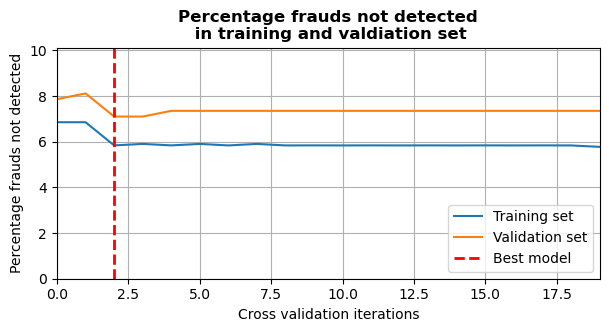

In [21]:
a = Logistic_model_und.cv_results_["mean_train_score"]
b = Logistic_model_und.cv_results_["mean_test_score"]

plot_training_test_errors(a,b, Logistic_model_und)

## 3.2 Randon Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier


We apply grid search as in the previous case.    
Considering that since the forest does not compare variable values but just split them it is not necessary to standardize the data.  
The parameters we want to optimize are:
  *  number of random trees to build ('model__n_estimators')
  *  max depth of the trees('model__max_depth')
  *  min samples to make a node split ('model__min_samples_split') 
  *  min samples to define a leaf ('model__min_samples_leaf')  




In [51]:
# RANOOM FOREST

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt'],
    'max_depth': [7, 8, 9],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

# GridSearchCV
rf_und = GridSearchCV(estimator=RandomForestClassifier(random_state= 0),
                      param_grid=param_grid,
                      scoring=make_scorer(frauds_not_detected, greater_is_better=False),
                      n_jobs=-1,
                      cv=5,
                      verbose=2,
                      error_score='raise',
                     return_train_score= True)

Random_forest_und = rf_und.fit(x_train, y_train)

# make predictions
y_pred_rf_und = Random_forest_und.predict(x_test)

# Calculate accuracy measures
print()
print('\033[1m\033[4mRandom Forest\033[0m')
print()
accuracy_measures(y_test, y_pred_rf_und)


Fitting 5 folds for each of 54 candidates, totalling 270 fits



Random Forest

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 14                84

Accuracy Score: 
92.39 %

Percentage of frauds not detected: 
14.29 %

Percentage of false alarms: 
1.01 %


In [24]:
print( "The best paraemters are: ")
print(Random_forest_und.best_estimator_.get_params(["classifier"]))

The best paraemters are: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


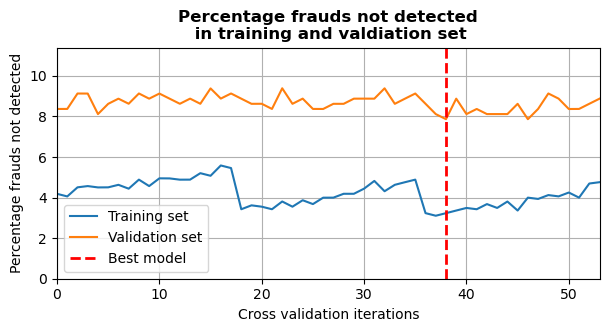

In [25]:
a = Random_forest_und.cv_results_["mean_train_score"]
b = Random_forest_und.cv_results_["mean_test_score"]

plot_training_test_errors(a,b, Random_forest_und)

The random forest seems to suffer from overfitting as it always performs better in the training set than in the test set.
Also during iterations it performs better on training but not better on validation score

In [26]:

print('\033[1m\033[4mTraining performance:\033[0m')
print()

train_pred = Random_forest_und.predict(x_train)
accuracy_measures(y_train, train_pred)


Training performance:

Confusion matrix: 
        legit prediction  fraud prediction
legit                391                 2
fraud                 14               380

Accuracy Score: 
97.97 %

Percentage of frauds not detected: 
3.55 %

Percentage of false alarms: 
0.51 %


### Improve Random Forest

We can try to reduce the overfitting in the random forest:
* increasing the number of trees generated
* increasing the min_sample_leaf 
* using less variables for each trees (log2)

In [50]:
#Random forest_und 2
param_grid = {
    'n_estimators': [200,400],
    'max_features': ['log2'],
    'max_depth': [6,7],
    'min_samples_split': [8],
    'min_samples_leaf': [2, 3],
    'bootstrap': [True]
}

# GridSearchCV
rf_und = GridSearchCV(estimator=RandomForestClassifier(random_state= 0),
                      param_grid=param_grid,
                      scoring=make_scorer(frauds_not_detected, greater_is_better=False),
                      n_jobs=-1,
                      cv=5,
                      verbose=2,
                      error_score='raise',
                     return_train_score= True)

Random_forest_und = rf_und.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf_und = Random_forest_und.predict(x_test)

# Calculate accuracy measures
accuracy_measures(y_test, y_pred_rf_und)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 15                83

Accuracy Score: 
91.88 %

Percentage of frauds not detected: 
15.31 %

Percentage of false alarms: 
1.01 %


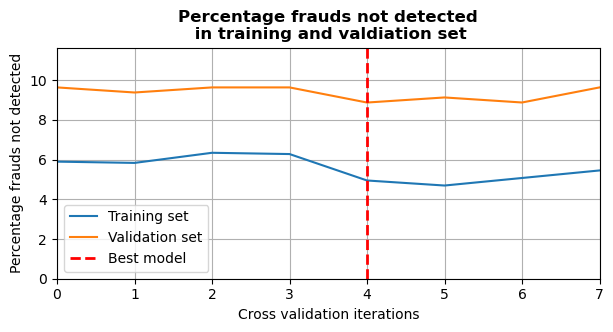

In [28]:
a = Random_forest_und.cv_results_["mean_train_score"]
b = Random_forest_und.cv_results_["mean_test_score"]

plot_training_test_errors(a,b, Random_forest_und)

In [29]:
train_pred = Random_forest_und.predict(x_train)
accuracy_measures(y_train, train_pred)

Confusion matrix: 
        legit prediction  fraud prediction
legit                392                 1
fraud                 21               373

Accuracy Score: 
97.2 %

Percentage of frauds not detected: 
5.33 %

Percentage of false alarms: 
0.25 %


The model does not improve because the error in the training increases but also increases in the test set.  
This means that the model does not generalize better but just becomes less accurate.

## 3.3 Naive Bayes 

In [30]:
from sklearn.naive_bayes import GaussianNB
from scipy.stats import shapiro

The naive bayes we test is the Gaussian naive bayes that allows us to use continuous features without resorting to   discretization.  
This model assumes a Gaussian distribution of the data which is present only in one feature of our dataset,  
 according to the Shapiro-Wilk Test.


In [31]:
#counter of normal variables in dataset
distributions= []
for column in data_undersample.columns:
    # p values of shapiro test
    stat, p_value = shapiro(data_undersample[column])
    # only significant variables are normal
    alpha = 0.05  
    if p_value > alpha:
       distributions.append("Normale")

print("Variables with normal distribution according to SW theorem: ",len(distributions))


Variables with normal distribution according to SW theorem:  1


However, we know from the literature that the model could perform well even without normal distribution of the data, so we will test it.
The only parameter to be optimized is var_smoothing that ensures that even if a feature has a variance close to 0, it will not cause numerical instability during the probability calculations.

In [32]:
# NAIVE BAYES

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GaussianNB())
])

param_grid = {
    "model__var_smoothing": np.logspace(0, -9, num=10)
}

# Create the GridSearchCV
gc_und = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(frauds_not_detected, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=2,
    error_score='raise',
    return_train_score=True)


Gaussian_naive_bayes_und = gc_und.fit(x_train, y_train)

# Make predictions on the test set
y_pred_nb = Gaussian_naive_bayes_und.predict(x_test)

# Calculate accuracy measures
print()
print('\033[1m\033[4mNaive Bayes\033[0m')
print()
accuracy_measures(y_test, y_pred_nb)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Naive Bayes

Confusion matrix: 
        legit prediction  fraud prediction
legit                 96                 3
fraud                 16                82

Accuracy Score: 
90.36 %

Percentage of frauds not detected: 
16.33 %

Percentage of false alarms: 
3.03 %


In [33]:
Gaussian_naive_bayes_und.best_estimator_.get_params(["classifier"])

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', GaussianNB(var_smoothing=0.001))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': GaussianNB(var_smoothing=0.001),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__priors': None,
 'model__var_smoothing': 0.001}

The naive bayes seems to be the model that suffers less from overfitting as we can see from the small difference between test and training performance and from the trend of training and validation along the search for optimal parameters .

In [34]:

print('\033[1m\033[4mTraining performance\033[0m')
print()
train_pred = Gaussian_naive_bayes_und.predict(x_train)
accuracy_measures(y_train, train_pred)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                384                 9
fraud                 49               345

Accuracy Score: 
92.63 %

Percentage of frauds not detected: 
12.44 %

Percentage of false alarms: 
2.29 %


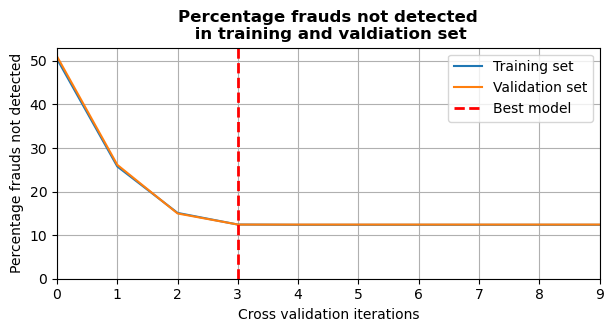

In [35]:
a = Gaussian_naive_bayes_und.cv_results_["mean_train_score"]
b = Gaussian_naive_bayes_und.cv_results_["mean_test_score"]

plot_training_test_errors(a,b,Gaussian_naive_bayes_und)

### Improve naive bayes

Naive bayes is based on the simplistic assumption of independence between variables.  
So we can try to improve it removing variables with very high correlation. 

In [36]:
#make correlation table
correlation_table= X.corr()

#remove variable under 0.8 of correlation
for column in correlation_table.columns:
    correlation_table[column] = np.where(abs(correlation_table[column]) < 0.8, np.nan, correlation_table[column])

#remove the diagonal that has ones
for i in correlation_table.columns:
    correlation_table[i] = np.where(correlation_table[i]== 1 , np.nan, correlation_table[i])


correlation_table= pd.DataFrame(correlation_table)

#drop rows full of na
correlation_table=correlation_table.dropna(how="all")

#drop columns full of na
correlation_table= correlation_table.dropna(how="all", axis= 1)
correlation_table



,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,V14,V16,V17,V18
V1,NaN,NaN,0.880144,NaN,0.864099,0.879825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V2,NaN,NaN,-0.858676,NaN,NaN,-0.849543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V3,0.880144,-0.858676,NaN,NaN,0.852964,0.886836,NaN,0.852698,NaN,NaN,NaN,NaN,NaN,NaN
V4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.832327,NaN,NaN,NaN,NaN
V5,0.864099,NaN,0.852964,NaN,NaN,0.836426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V7,0.879825,-0.849543,0.886836,NaN,0.836426,NaN,NaN,0.866785,NaN,NaN,NaN,NaN,NaN,NaN
V9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.847317,NaN,NaN,NaN,NaN,NaN,NaN
V10,NaN,NaN,0.852698,NaN,NaN,0.866785,0.847317,NaN,-0.803747,0.884165,NaN,0.854633,0.853991,0.802649
V11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.803747,NaN,-0.903692,-0.891255,-0.807144,NaN,NaN
V12,NaN,NaN,NaN,-0.832327,NaN,NaN,NaN,0.884165,-0.903692,NaN,0.882138,0.899616,0.879854,0.800467


In [37]:
to_drop = [column for column in correlation_table.columns if any(correlation_table[column] > 0.95)]

print("Variables higly collinear to drop: ", to_drop)

Variables higly collinear to drop:  ['V16', 'V17']


In [38]:
# NAIVE BAYES WITHOUT V16 E V18

data_undersample.drop(to_drop, axis= 1)
X2 = data_undersample.drop('Class', axis=1) 
Y2 = data_undersample['Class']       

x_train2 , x_test2 , y_train2 , y_test2 = train_test_split (X2 , Y2 , test_size = 0.2,
                                                        stratify=Y,
                                                        random_state = 0)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GaussianNB())
])

param_grid = {
    "model__var_smoothing": np.logspace(0, -9, num=100)
}

# Create the GridSearchCV
gc_und = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(frauds_not_detected, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=2,
    error_score='raise'
)
# Fit & predict
Guassian_naive_bayes_und = gc_und.fit(x_train2, y_train2)
y_pred = Guassian_naive_bayes_und.predict(x_test2)

# Accuracy measures
print()
print('\033[1m\033[4mNaive Bayes\033[0m')
print()

accuracy_measures(y_test2, y_pred)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Naive Bayes

Confusion matrix: 
        legit prediction  fraud prediction
legit                 96                 3
fraud                 17                81

Accuracy Score: 
89.85 %

Percentage of frauds not detected: 
17.35 %

Percentage of false alarms: 
3.03 %


In [39]:

print('\033[1m\033[4mTraining performance\033[0m')
print()
accuracy_measures(y_test, y_pred_lm_und)
train_pred = Gaussian_naive_bayes_und.predict(x_train)
accuracy_measures(y_train2, train_pred)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 13                85

Accuracy Score: 
92.89 %

Percentage of frauds not detected: 
13.27 %

Percentage of false alarms: 
1.01 %
Confusion matrix: 
        legit prediction  fraud prediction
legit                384                 9
fraud                 49               345

Accuracy Score: 
92.63 %

Percentage of frauds not detected: 
12.44 %

Percentage of false alarms: 
2.29 %


We did not manage to improve the Naive bayes.  
* first model errors: 17.35 in test set and  12.44 in training set  
* second model errors: 14.29 and 12.97

## 3.4 Support Vector Classifier 

In [40]:
from sklearn.svm import SVC  

The last classifier we are going to test is the SVC.
The parameters to be optimized are:
1. C : trade off between margin width and misclassification.  
    * High C indicates narrower margin and more precise classification.  
    * Low C indicates wider margin and less precise classification.
2. Kernel function to map the data in a higer dimesnionality  
    * linear
    * polinomial 
    * radial
3. Degree of the polinomialfucntion between 2,3,4



In [41]:

C= np.arange(1, 10, 0.5, dtype= float)

param_grid={
    "model__C": C,
    "model__kernel": ["linear","poly" ,"rbf" ],
    "model__degree": [2,3,4]}

pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("model", SVC(random_state=0))
])
# Create the GridSearchCV
svc_und = GridSearchCV(
    estimator= pipeline,
    param_grid=param_grid,
    scoring=make_scorer(frauds_not_detected, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=2,
    error_score='raise',
    return_train_score=True
)

SVC_und = svc_und.fit(x_train, y_train)

# Make predictions on the test set
y_pred_svc = SVC_und.predict(x_test)

# Calculate accuracy measures
print()
print('\033[1m\033[4mSVC\033[0m')
print()

accuracy_measures(y_test, y_pred_svc)


Fitting 5 folds for each of 162 candidates, totalling 810 fits



SVC

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 14                84

Accuracy Score: 
92.39 %

Percentage of frauds not detected: 
14.29 %

Percentage of false alarms: 
1.01 %


In [42]:
print("Best parameters are: ")
SVC_und.best_estimator_.get_params(["classifier"])

Best parameters are: 


{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model', SVC(C=4.5, degree=2, kernel='linear', random_state=0))],
 'verbose': False,
 'scaler': StandardScaler(),
 'model': SVC(C=4.5, degree=2, kernel='linear', random_state=0),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 4.5,
 'model__break_ties': False,
 'model__cache_size': 200,
 'model__class_weight': None,
 'model__coef0': 0.0,
 'model__decision_function_shape': 'ovr',
 'model__degree': 2,
 'model__gamma': 'scale',
 'model__kernel': 'linear',
 'model__max_iter': -1,
 'model__probability': False,
 'model__random_state': 0,
 'model__shrinking': True,
 'model__tol': 0.001,
 'model__verbose': False}

From the plot we can clearly see the overfitting effect: train and validation scres diverge.

In [43]:
print('\033[1m\033[4mTraining performance\033[0m')
print()
y_pred_svc = SVC_und.predict(x_train)
# Calculate accuracy measures
accuracy_measures(y_train, y_pred_svc)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                388                 5
fraud                 25               369

Accuracy Score: 
96.19 %

Percentage of frauds not detected: 
6.35 %

Percentage of false alarms: 
1.27 %


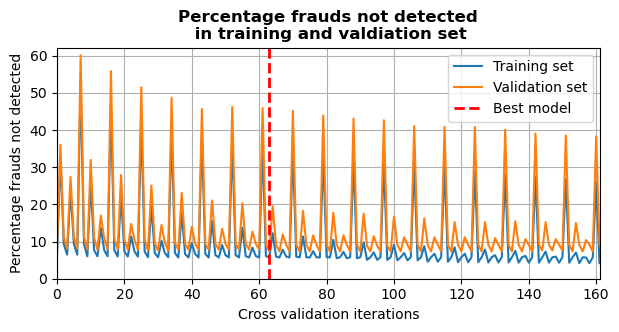

In [44]:
a = SVC_und.cv_results_["mean_train_score"]
b = SVC_und.cv_results_["mean_test_score"]

plot_training_test_errors(a,b,SVC_und)

# 4 Identify the best model

Identifying the best model is not easy and requires a small paragraph aside.  
The table below shows that in terms of accuracy the best models are the Random Forest and Logistic (92.89 % accuracy).  
If we want also to consider the minimal difference in training and test set as hint of less risk in overfitting we can state that probably the ebst model   is the Logistic (best accuracy and second smallest difference in train and test set).

In [56]:
import tabulate as tabulate
accuracy= {
    "accuracy in test": [92.89, 92.89, 90.36,92.39],
    "accuracy in train": [96.06,97.97,92.63,96.19],   
}
df_acc = pd.DataFrame(accuracy, index=['Logistic', 'Random Forest',"Naive Bayes", "SVC"])

#add difference column
df_acc["difference"] = df_acc["accuracy in train"]- df_acc["accuracy in test"]
df_acc = df_acc.round(2)
#pretty print 
table = tabulate.tabulate(df_acc, headers="keys", tablefmt="pretty")
print(table)

+---------------+------------------+-------------------+------------+
|               | accuracy in test | accuracy in train | difference |
+---------------+------------------+-------------------+------------+
|   Logistic    |      92.89       |       96.06       |    3.17    |
| Random Forest |      92.89       |       97.97       |    5.08    |
|  Naive Bayes  |      90.36       |       92.63       |    2.27    |
|      SVC      |      92.39       |       96.19       |    3.8     |
+---------------+------------------+-------------------+------------+


Even if we compare the models solely on the basis of unidentified fraud probably the logistic model remains the best  
(smallest error and second smallest difference).
Moreover, in this case the random forest seems to suffer from overfitting,
and this strengthens our hypothesis that logistic regression is better for this type of problem.

In [57]:

models_err= {
    "error in test": [13.27, 14.29, 16.33, 14.29 ],
    "error in train": [6.35, 3.55, 12.44, 6.35],
}
df_err = pd.DataFrame(models_err, index=['Logistic', 'Random Forest',"Naive Bayes", "SVC"])
df_err["difference"] = df_err["error in test"]- df_err["error in train"]
df_err = df_err.round(2)
table2 = tabulate.tabulate(df_err, headers="keys", tablefmt="pretty")
print(table2)

+---------------+---------------+----------------+------------+
|               | error in test | error in train | difference |
+---------------+---------------+----------------+------------+
|   Logistic    |     13.27     |      6.35      |    6.92    |
| Random Forest |     14.29     |      3.55      |   10.74    |
|  Naive Bayes  |     16.33     |     12.44      |    3.89    |
|      SVC      |     14.29     |      6.35      |    7.94    |
+---------------+---------------+----------------+------------+


# 5 Weighted Undersampling

To conclude our analysis, we need to test whether the large data loss due to undersample has worsened the models by seeing if our conclusions change using more data.
Themost famous alternative sampling methods could be:
* Oversampling: oversampling the minority class to create a balanced dataset.
* Weights: apply weights inversely proportional to class frequency. 
* SMOTE: oversampling by creating new data.

The problem, unfortunately, is that:  
* Oversampling or use the whole dataset with weights lengthens the training time of models too much  
* SMOTE method creates new data but we don't know the variables in our dataset so we could generate misleading data points  

The fourth way could be 
undersampling with a 1:100 ratio of legit and frauds transactions, weighing the data inversely with respect to their class frequency.
This allows to:   
* increases the dataset  
* have less computationally expensive training  

N.B. To reduce the training time some parameters are already changed according to the previous results.

In [58]:
     
#load data 
data= pd.read_csv(r"C:\Users\Utente\OneDrive\Desktop\coding_project2\creditcard.csv")

Amount = data["Amount"]
Class = data["Class"]
data.pop("Class")
data.pop("Amount")
data.insert(0,"Amount", Amount)
data.insert(0, "Class", Class)
data.head(2)

legit_transaction= data[data.Class == 0]
fraud_transaction= data[data.Class == 1]



# UNDERSAMPLING  with diff ratio
sample_fraud_transaction = fraud_transaction

n = 100
N = 492 * n
sample_legit_transaction = legit_transaction.sample(n= N,
                                                    replace= False, #replace false to avoid doubleS
                                                    random_state = 0)

data_undersample = pd.concat([sample_fraud_transaction, sample_legit_transaction], axis= 0)

#train test split
X = data_undersample.drop(columns='Class', axis=1) #use std features
Y = data_undersample['Class']      

## 5.1 Weighted Logistic Model 

In [59]:

# Define parameters to optimize

C = [3,6,7,10]

param_grid = {'model__penalty': ['l1'], "model__solver": [ 'liblinear'], "model__C": C}

                    

# Make pipeline to scale during the grid search
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=0,
                                class_weight="balanced"))  #add class weight
])


# Create the GridSearch
Logistic_model = GridSearchCV(estimator=pipeline,
                                param_grid=param_grid,
                                scoring=make_scorer(frauds_not_detected, greater_is_better=False),
                                n_jobs=-1,
                                cv=5,
                                verbose=2,
                                error_score='raise',
                              return_train_score=True)
# Fit the grid search on the training data
Logistic_model_wei = Logistic_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_lm_wei= Logistic_model_wei.predict(x_test)

# Calculate accuracy measure
print()
print('\033[1m\033[4mLogistic Model wei\033[0m')
print()
accuracy_measures(y_test, y_pred_lm_wei)
a = Logistic_model_wei.cv_results_["mean_train_score"]
b = Logistic_model_wei.cv_results_["mean_test_score"]




Fitting 5 folds for each of 4 candidates, totalling 20 fits



Logistic Model weiCV

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 13                85

Accuracy Score: 
92.89 %

Percentage of frauds not detected: 
13.27 %

Percentage of false alarms: 
1.01 %


In [60]:
# accuracy measures training set
print('\033[1m\033[4mTraining performance\033[0m')
print()
train_pred = Logistic_model_wei.predict(x_train)
accuracy_measures(y_train, train_pred)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                388                 5
fraud                 25               369

Accuracy Score: 
96.19 %

Percentage of frauds not detected: 
6.35 %

Percentage of false alarms: 
1.27 %


## 5.2 Weighted Random Forest 

In [64]:

param_grid = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'max_depth': [7],
    'min_samples_split': [7],
    'min_samples_leaf': [2],
    'bootstrap': [True]
}
# GridSearchCV
rf_wei = GridSearchCV(estimator = RandomForestClassifier(random_state = 0 ,class_weight="balanced"),
            param_grid=param_grid,
            scoring=make_scorer(frauds_not_detected, greater_is_better=False),
            n_jobs=-1,
            cv=5,
            verbose=2,
            error_score='raise',
            return_train_score= True)

Random_forest_wei = rf_wei.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf_wei = Random_forest_wei.predict(x_test)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [65]:

# accuracy test set 
print()
print('\033[1m\033[4mRandom Forest wei\033[0m')
print()
accuracy_measures(y_test, y_pred_rf_wei)

a = Random_forest_wei.cv_results_["mean_train_score"]
b = Random_forest_wei.cv_results_["mean_test_score"]




Random Forest weiCV

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 15                83

Accuracy Score: 
91.88 %

Percentage of frauds not detected: 
15.31 %

Percentage of false alarms: 
1.01 %


In [66]:
# accuracy measures training set
print('\033[1m\033[4mTraining performance\033[0m')
print()
y_pred_rf_wei = Random_forest_wei.predict(x_train)

accuracy_measures(y_train, y_pred_rf_wei)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                392                 1
fraud                 18               376

Accuracy Score: 
97.59 %

Percentage of frauds not detected: 
4.57 %

Percentage of false alarms: 
0.25 %


## 5.3 Weighted Naive bayes

In [75]:
# NAIVE BAYES wei

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GaussianNB())
])

param_grid = {
    "model__var_smoothing": np.logspace(0, -9, num=10)
}

# Create the GridSearchCV
gc_wei = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(frauds_not_detected, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=2,
    error_score='raise',
    return_train_score=True)


Gaussian_naive_bayes_wei = gc_wei.fit(x_train, y_train)

# Make predictions on the test set
y_pred_nb = Gaussian_naive_bayes_wei.predict(x_test)

# Calculate accuracy measures
print()
print('\033[1m\033[4mNaive Bayes wei\033[0m')
print()
accuracy_measures(y_test, y_pred_nb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits



Naive Bayes wei

Confusion matrix: 
        legit prediction  fraud prediction
legit                 96                 3
fraud                 16                82

Accuracy Score: 
90.36 %

Percentage of frauds not detected: 
16.33 %

Percentage of false alarms: 
3.03 %


In [76]:
# accuracy measures training set
print('\033[1m\033[4mTraining performance\033[0m')
print()
y_pred_nb = Gaussian_naive_bayes_wei.predict(x_train)
accuracy_measures(y_train, y_pred_nb)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                384                 9
fraud                 49               345

Accuracy Score: 
92.63 %

Percentage of frauds not detected: 
12.44 %

Percentage of false alarms: 
2.29 %


## 5.4 Weighted SVC

In [69]:
from sklearn.svm import SVC 
C= np.arange(4, 10, 2, dtype= float)


param_grid = {
    "model__C": C,
    "model__kernel": ["linear"]
}
pipeline = Pipeline([
    ("scaler", StandardScaler()),  
    ("model", SVC(random_state=0,
                  class_weight= 'balanced'))
])
# Create the GridSearchCV
svc_wei = GridSearchCV(
    estimator= pipeline,
    param_grid=param_grid,
    scoring=make_scorer(frauds_not_detected, greater_is_better=False),
    n_jobs=-1,
    cv=5,
    verbose=2,
    error_score='raise',
    return_train_score=True
)

SVC_wei = svc_wei.fit(x_train, y_train)

# Make predictions on the test set
y_pred_svc = SVC_wei.predict(x_test)

# Calculate accuracy measures
print()
print('\033[1m\033[4mSVC weiCV\033[0m')
print()
accuracy_measures(y_test, y_pred_svc)

a = Gaussian_naive_bayes_wei.cv_results_["mean_train_score"]
b = Gaussian_naive_bayes_wei.cv_results_["mean_test_score"]



Fitting 5 folds for each of 3 candidates, totalling 15 fits



SVC weiCV

Confusion matrix: 
        legit prediction  fraud prediction
legit                 98                 1
fraud                 14                84

Accuracy Score: 
92.39 %

Percentage of frauds not detected: 
14.29 %

Percentage of false alarms: 
1.01 %


In [70]:
# accuracy measures training set
print('\033[1m\033[4mTraining performance\033[0m')
print()
y_pred_svc = SVC_wei.predict(x_train)
accuracy_measures(y_train, y_pred_svc)

Training performance

Confusion matrix: 
        legit prediction  fraud prediction
legit                388                 5
fraud                 25               369

Accuracy Score: 
96.19 %

Percentage of frauds not detected: 
6.35 %

Percentage of false alarms: 
1.27 %


# 6 Conclusion

Even trying to use more data using weighted undersampling with ratio 1:100 the conclusions do not change  
 and the logistic model seems the best model to use, as we can see from the table below.

In [78]:
accuracy_wei= {
    "accuracy in test": [92.89, 91.88, 90.36, 92.39],
    "accuracy in train": [96.19,97.59,92.63, 96.19],   
}
df_acc_wei = pd.DataFrame(accuracy_wei, index=['Logistic', 'Random Forest',"Naive Bayes", "SVC"])
#add difference column
df_acc_wei["difference"] = df_acc_wei["accuracy in train"]- df_acc_wei["accuracy in test"]
df_acc_wei = df_acc.round(2)
#pretty print 
table = tabulate.tabulate(df_acc, headers="keys", tablefmt="pretty")
print(table)



+---------------+------------------+-------------------+------------+
|               | accuracy in test | accuracy in train | difference |
+---------------+------------------+-------------------+------------+
|   Logistic    |      92.89       |       96.06       |    3.17    |
| Random Forest |      92.89       |       97.97       |    5.08    |
|  Naive Bayes  |      90.36       |       92.63       |    2.27    |
|      SVC      |      92.39       |       96.19       |    3.8     |
+---------------+------------------+-------------------+------------+


In [79]:
models_err= {
    "error in test": [13.27, 15.31, 16.33, 14.29 ],
    "error in train": [6.35, 4.57, 12.44, 6.35],
}
df_err_wei = pd.DataFrame(models_err, index=['Logistic', 'Random Forest',"Naive Bayes", "SVC"])
#add difference column
df_err_wei["difference"] = df_err_wei["error in test"]- df_err_wei["error in train"]
df_err_wei = df_err.round(2)
table2 = tabulate.tabulate(df_err_wei, headers="keys", tablefmt="pretty")
print(table2)

+---------------+---------------+----------------+------------+
|               | error in test | error in train | difference |
+---------------+---------------+----------------+------------+
|   Logistic    |     13.27     |      6.35      |    6.92    |
| Random Forest |     14.29     |      3.55      |   10.74    |
|  Naive Bayes  |     16.33     |     12.44      |    3.89    |
|      SVC      |     14.29     |      6.35      |    7.94    |
+---------------+---------------+----------------+------------+
